## Importing dependencies

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
import os 
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [121]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [122]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Removing unwanted images

In [123]:
data_dir = 'data'

In [124]:
image_extensions = ['jpeg','jpg', 'bmp']

In [125]:
#looping through the data directories to get all the images and then making sure they are in the right format

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('No issue with image {}'.format(image_path))

## Loading in data with tensorflow

In [126]:
#this will automatically reshape our images to 256x256 and the batch size will be 32(defualt)
#this will also create labels for our data as well
#images in the non_potatoes directory  will be labelled as 0 and the ones in the potatoes directory will be labelled as 1
data = tf.keras.preprocessing.image_dataset_from_directory('data')

Found 338 files belonging to 3 classes.


In [127]:
data_iterator = data.as_numpy_iterator()

In [128]:
#this will get the batches created
batch = data_iterator.next()

In [129]:
#images have been turned to numpy arrays to run through the cnn
batch[0]

array([[[[131.66406  , 148.66406  ,  56.664062 ],
         [ 95.44141  , 112.66406  ,  20.886719 ],
         [ 88.19531  , 107.38086  ,  17.566406 ],
         ...,
         [119.       , 176.       , 121.       ],
         [119.       , 176.       , 121.       ],
         [119.       , 176.       , 121.       ]],

        [[ 87.68791  , 108.14274  ,  25.044151 ],
         [100.97852  , 122.07962  ,  32.59134  ],
         [109.88887  , 131.93575  ,  44.51654  ],
         ...,
         [119.       , 176.       , 121.       ],
         [119.       , 176.       , 121.       ],
         [119.       , 176.       , 121.       ]],

        [[ 63.812397 ,  89.997055 ,  13.445759 ],
         [ 85.68739  , 112.55849  ,  29.470787 ],
         [102.40914  , 129.4125   ,  48.599415 ],
         ...,
         [119.       , 176.       , 121.       ],
         [119.       , 176.       , 121.       ],
         [119.       , 176.       , 121.       ]],

        ...,

        [[119.       , 176.       , 12

In [130]:
#all the labels  for the images
#0 = non_potatoes
#1 = potatoes
batch[1]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1], dtype=int32)

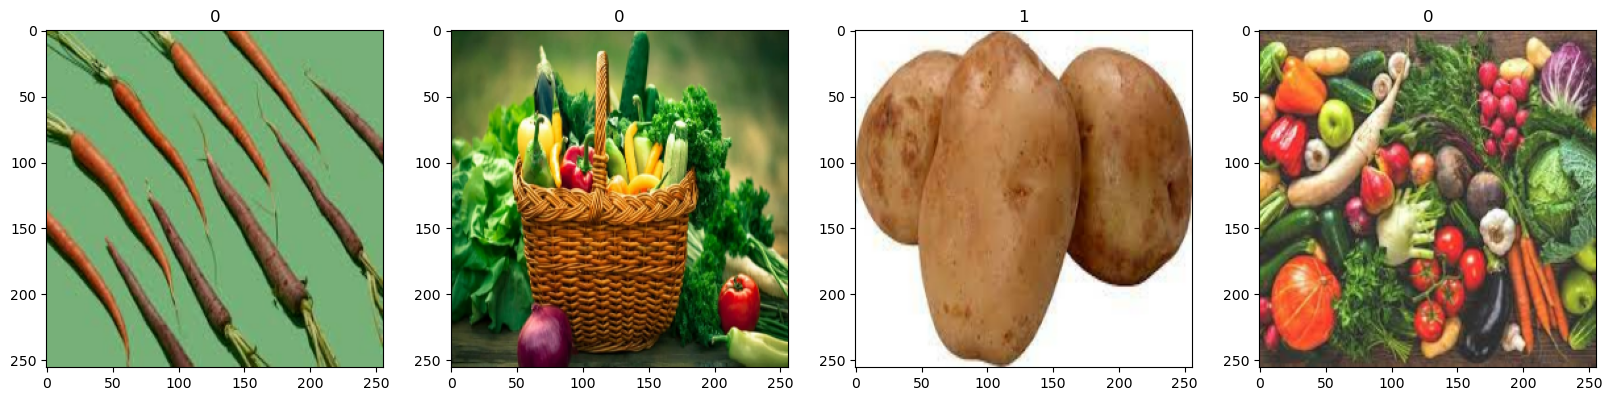

In [131]:
#visualising some images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Scale data values to be between 0 and 1. 

In [132]:
#This will make the model generalise faster and produce better results
data = data.map(lambda x,y: (x/255, y))

In [133]:
#scaled data
data.as_numpy_iterator().next()

(array([[[[0.70064336, 0.8281863 , 0.9064338 ],
          [0.62068015, 0.7556985 , 0.8587929 ],
          [0.5087316 , 0.65291053, 0.78590685],
          ...,
          [0.97679514, 0.8317402 , 0.41421235],
          [0.9794053 , 0.82591265, 0.39735875],
          [0.95747334, 0.79766726, 0.32517305]],
 
         [[0.7030637 , 0.82650125, 0.90680146],
          [0.61827105, 0.7547375 , 0.8571078 ],
          [0.50070465, 0.6551471 , 0.7842218 ],
          ...,
          [0.9586976 , 0.76896113, 0.32768267],
          [0.9622968 , 0.7981424 , 0.38159013],
          [0.9596926 , 0.80114484, 0.37076393]],
 
         [[0.70643383, 0.8210586 , 0.9034115 ],
          [0.6032152 , 0.75242203, 0.8492647 ],
          [0.48670343, 0.6504902 , 0.7756434 ],
          ...,
          [0.9682756 , 0.771278  , 0.29835397],
          [0.9644591 , 0.7973329 , 0.3797744 ],
          [0.9747027 , 0.81566644, 0.40879288]],
 
         ...,
 
         [[0.94036984, 0.8699025 , 0.76367235],
          [0.89024

## Split data in training and testing batches

In [134]:
#number of batches consisting of 32 images 
len(data)

11

In [135]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [136]:
test_size+val_size+train_size

11

In [137]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Making the CNN model

In [138]:
model = Sequential()

In [139]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [140]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [141]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)            

In [143]:
model.fit(train, epochs=25, validation_data=val)

Epoch 1/25
7/7 [==============================] - 9s 865ms/step - loss: -0.2906 - accuracy: 0.9330 - val_loss: 0.5207 - val_accuracy: 0.9062
Epoch 2/25
7/7 [==============================] - 9s 1s/step - loss: -0.4272 - accuracy: 0.9598 - val_loss: 0.1744 - val_accuracy: 0.9688
Epoch 3/25
7/7 [==============================] - 9s 933ms/step - loss: -0.8475 - accuracy: 0.9554 - val_loss: -0.3255 - val_accuracy: 0.9844
Epoch 4/25
7/7 [==============================] - 10s 1s/step - loss: -0.7634 - accuracy: 0.9152 - val_loss: -2.1556 - val_accuracy: 0.9375
Epoch 5/25
7/7 [==============================] - 9s 927ms/step - loss: -0.8834 - accuracy: 0.9509 - val_loss: -1.8228 - val_accuracy: 0.9844
Epoch 6/25
7/7 [==============================] - 9s 886ms/step - loss: 0.2349 - accuracy: 0.9509 - val_loss: 0.3465 - val_accuracy: 0.9219
Epoch 7/25
7/7 [==============================] - 9s 909ms/step - loss: -1.3552 - accuracy: 0.9688 - val_loss: 0.1858 - val_accuracy: 0.9688
Epoch 8/25
7/7 [

##  Evaluate the model

In [144]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [145]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

In [146]:
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

Precision: 0.9523809552192688, Recall: 1.0, Accuracy: 0.9565972089767456


## Testing the model

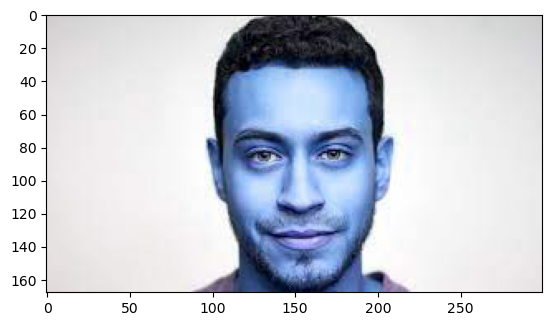

In [207]:
#loading image of a persons face
img = cv2.imread('data/test/face.jpg')
plt.imshow(img)
plt.show()

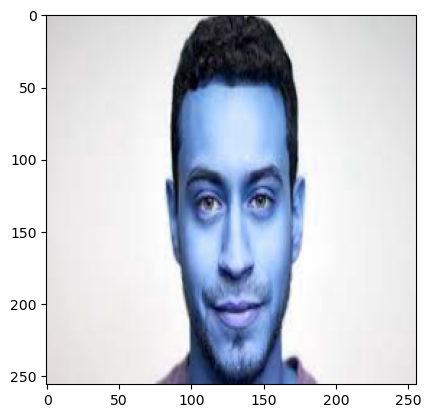

In [208]:
#resizing the image to pass through the CNN model
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [210]:
#The CNN expects the input image to be in a batch of images. So it is required to add another dimension to the single image input
yhat = model.predict(np.expand_dims(resize/255, 0))

In [211]:
yhat

array([[7.641047e-08]], dtype=float32)

In [215]:
if yhat > 0.5: 
    print(f'This is a Potato')
else:
    print(f'This is not a potato')

This is not a potato


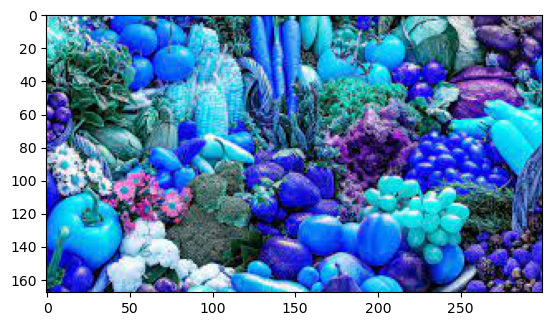

In [221]:
#loaading an image of a vegetables
img = cv2.imread('data/test/vegetables.jpg')
plt.imshow(img)
plt.show()

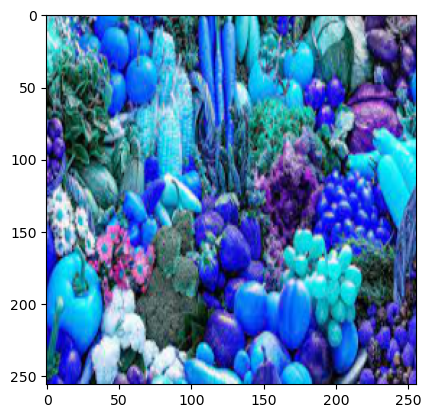

In [222]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [223]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [224]:
yhat

array([[0.02970073]], dtype=float32)

In [225]:
if yhat > 0.5: 
    print(f'This is a Potato')
else:
    print(f'This is not a potato')

This is not a potato


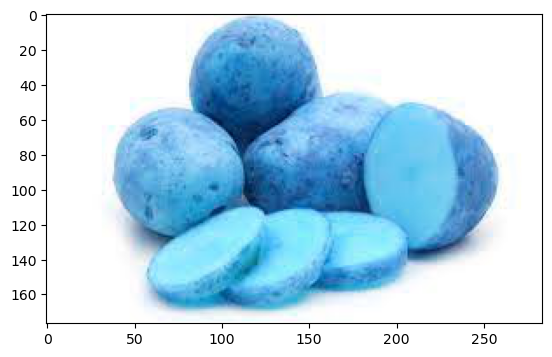

In [227]:
#loaading an image of a potato
img = cv2.imread('data/test/potato.jpg')
plt.imshow(img)
plt.show()

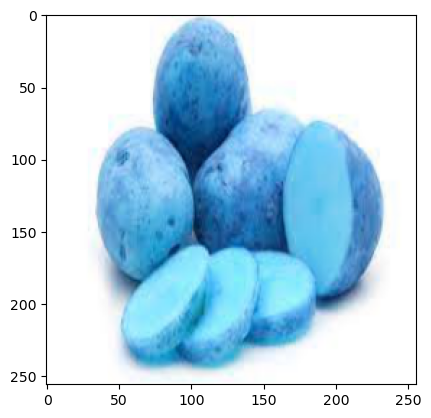

In [228]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [229]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [230]:
yhat

array([[0.9999964]], dtype=float32)

In [231]:
if yhat > 0.5: 
    print(f'This is a Potato')
else:
    print(f'This is not a potato')

This is a Potato


## Save the model

In [259]:
model.save(os.path.join('models','imageclassifier.h5'))

In [260]:
#Testing to see if the model can be loading properly
new_model = load_model('models/imageclassifier.h5')

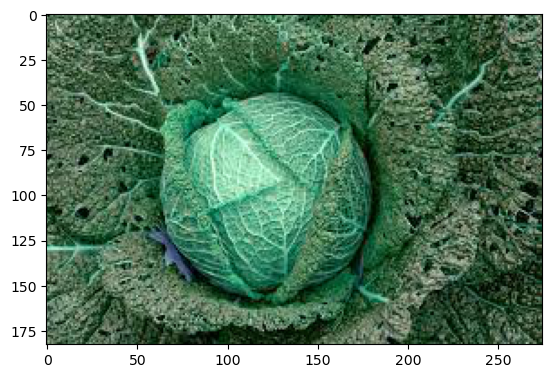

In [261]:
#loading image of a persons face
img = cv2.imread('data/test/cabbage.jpg')
plt.imshow(img)
plt.show()

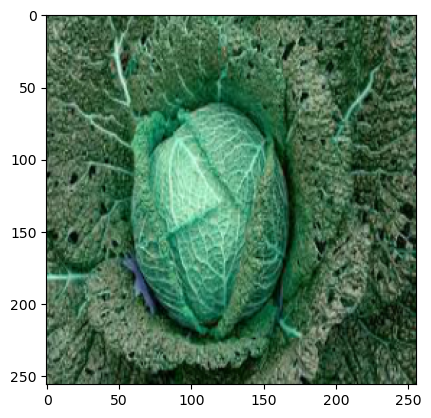

In [262]:
#resizing the image to pass through the CNN model
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [263]:
yhat = new_model.predict(np.expand_dims(resize/255, 0))

In [264]:
yhat

array([[0.]], dtype=float32)

In [265]:
if yhat > 0.5: 
    print(f'This is a Potato')
else:
    print(f'This is not a potato')

This is not a potato


## Findings

As you can see from the above tests the model is predicting images it hs not seen before with an accuracy of 100%. This isn't a final score for the model as there would be a need to test it on a much large sample data consisting of images of various types of objects.